# Clusterização de angulação do fluxo de pessoas

In [1]:
import pandas as pd
import math
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('multscale/out.csv')

df.head()

,frame,i,x1,y1,x2,y2,x,y,angle,size
0,5,0,31,155,32,155,-1,0,3.141593,1.0
1,5,1,10,197,10,197,0,0,0.000000,0.0
2,5,2,37,118,37,118,0,0,0.000000,0.0
3,5,3,6,38,6,39,0,-1,-1.570796,1.0
4,5,4,10,154,10,154,0,0,0.000000,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63093 entries, 0 to 63092
Data columns (total 10 columns):
frame    63093 non-null int64
i        63093 non-null int64
x1       63093 non-null int64
y1       63093 non-null int64
x2       63093 non-null int64
y2       63093 non-null int64
x        63093 non-null int64
y        63093 non-null int64
angle    63093 non-null float64
size     63093 non-null float64
dtypes: float64(2), int64(8)
memory usage: 4.8 MB


In [4]:
def cart2pol(x, y):
    """Convert from Cartesian to polar coordinates.

    Example
    -------
    >>> theta, radius = pol2cart(x, y)
    """
    radius = np.hypot(x, y)
    theta = np.arctan2(y, x)
    return theta, radius

def compass(angles, radii, arrowprops=dict(color='darkorange', linewidth=2)):
    """
    Compass draws a graph that displays the vectors with
    components `u` and `v` as arrows from the origin.

    Examples
    --------
    >>> import numpy as np
    >>> u = [+0, +0.5, -0.50, -0.90]
    >>> v = [+1, +0.5, -0.45, +0.85]
    >>> compass(u, v)
    """

    #angles, radii = cart2pol(u, v)

    fig, ax = plt.subplots(subplot_kw=dict(polar=True))

    kw = dict(arrowstyle="->", color='k')
    if arrowprops:
        kw.update(arrowprops)
    [ax.annotate("", xy=(angle, radius), xytext=(0, 0),
                 arrowprops=kw) for
     angle, radius in zip(angles, radii)]

    ax.set_ylim(0, np.max(radii))

    return fig, ax

### Distribuição dos dados

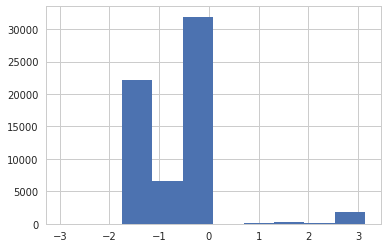

In [5]:
df.angle.hist()

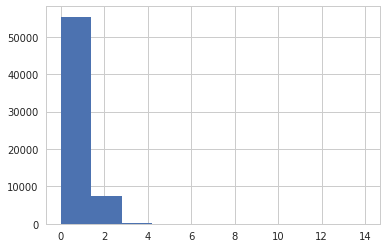

In [6]:
df['size'].hist()

# Clusterizacao do Angulo

In [7]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.externals import joblib

In [8]:
n_clusters=2
X = df[['angle']]

### Kmeans

In [9]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [10]:
cluster_centers_ = kmeans.cluster_centers_.flatten()
cluster_centers_

array([ 0.18296538, -1.39315747])

In [11]:
df['cluster'] = kmeans.predict(X)

In [12]:
# save
joblib.dump(kmeans, 'kmeans.pkl') 
kmeans = joblib.load('kmeans.pkl') 
kmeans.predict(-1.4)[0]

1

### DBSCAN

In [13]:
df.head()

,frame,i,x1,y1,x2,y2,x,y,angle,size,cluster
0,5,0,31,155,32,155,-1,0,3.141593,1.0,0
1,5,1,10,197,10,197,0,0,0.000000,0.0,0
2,5,2,37,118,37,118,0,0,0.000000,0.0,0
3,5,3,6,38,6,39,0,-1,-1.570796,1.0,1
4,5,4,10,154,10,154,0,0,0.000000,0.0,0


In [35]:
from sklearn.preprocessing import StandardScaler

# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(df[['x1', 'y1']])

In [36]:
dbscan = DBSCAN(eps=0.9, min_samples=50, n_jobs=-1).fit(X)

In [37]:
labels = dbscan.labels_
labels

array([0, 0, 0, ..., 0, 0, 0])

In [38]:
#Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters

1

In [39]:
df['cluster'] = labels

## Analytics

In [18]:
df.head()

,frame,i,x1,y1,x2,y2,x,y,angle,size,cluster
0,5,0,31,155,32,155,-1,0,3.141593,1.0,0
1,5,1,10,197,10,197,0,0,0.000000,0.0,0
2,5,2,37,118,37,118,0,0,0.000000,0.0,0
3,5,3,6,38,6,39,0,-1,-1.570796,1.0,1
4,5,4,10,154,10,154,0,0,0.000000,0.0,0


In [19]:
#sorted(df.angle.unique())
#math.atan2(y2, x2)

In [20]:
# x1 = 5
# y1 = 5

# x2 = 5
# y2 = -5

# fig, ax = compass([math.atan2(y1, x1), math.atan2(y2, x2)], [1,1,1,1])

In [21]:
df_angle = df.groupby(['angle']).agg({'size': 'sum', 'cluster': 'max'}).reset_index()
df_angle.head()

,angle,size,cluster
0,-2.976444,6.082763,1
1,-2.896614,8.246211,1
2,-2.819842,12.649111,1
3,-2.677945,69.318107,1
4,-2.356194,11.313708,1


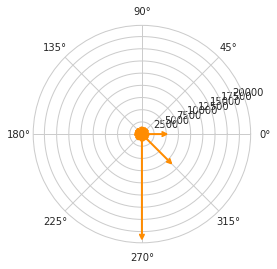

In [22]:
# Todos os Angulos
fig, ax = compass(df_angle.angle.values, df_angle['size'].values)

In [23]:
df_cluster = df.groupby(['cluster']).agg('sum').reset_index()
df_cluster.head()

,cluster,frame,i,x1,y1,x2,y2,x,y,angle,size
0,0,27952637,696731,4901159,4100529,4896363,4100419,4796,110,6254.488449,9327.304609
1,1,23731836,573514,4242036,3186503,4235463,3215729,6573,-29226,-40274.789338,32048.872872


In [24]:
df_cluster['angle'] = df_cluster.apply(lambda row: math.atan2(row.y, row.x), axis=1)

[ 0.02293176 -1.3495747 ]


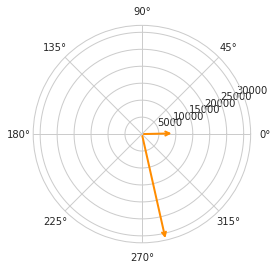

In [25]:
# Angulos do SOmatório
print(df_cluster.angle.values)
fig, ax = compass(df_cluster.angle.values, df_cluster['size'].values)

[ 0.18296538 -1.39315747]


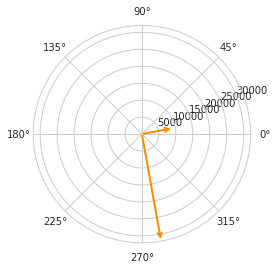

In [26]:
#  Angulos do centroid do Cluster
size = [df[df.cluster == c]['size'].sum() for c in range(len(cluster_centers_)) ]
print(cluster_centers_)
fig, ax = compass(cluster_centers_, size)

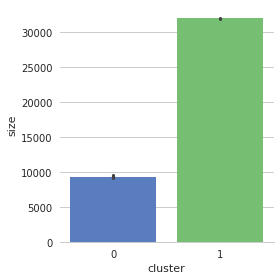

In [27]:
g = sns.factorplot(x="cluster", y="size", data=df, kind="bar", palette="muted", estimator=sum)
g.despine(left=True)

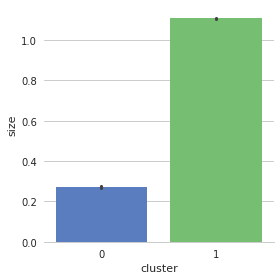

In [28]:
g = sns.factorplot(x="cluster", y="size", data=df, kind="bar", palette="muted")
g.despine(left=True)

In [29]:
df.head()

,frame,i,x1,y1,x2,y2,x,y,angle,size,cluster
0,5,0,31,155,32,155,-1,0,3.141593,1.0,0
1,5,1,10,197,10,197,0,0,0.000000,0.0,0
2,5,2,37,118,37,118,0,0,0.000000,0.0,0
3,5,3,6,38,6,39,0,-1,-1.570796,1.0,1
4,5,4,10,154,10,154,0,0,0.000000,0.0,0


In [30]:
# import matplotlib.pyplot as plt

# ax = plt.axes()
# for i, row in df[df.cluster == 1].iterrows():
#     ax.arrow(row.x1, row.y1, row.x2, row.y2, head_width=0.05, head_length=0.1, fc='k', ec='k')
# #ax.arrow(0, 0, 0.5, 0.5, head_width=0.05, head_length=0.1, fc='k', ec='k')

# plt.show()

## Print Arrows Flow

![Image of Yaktocat](sample.png)

In [31]:
def plot_arrows(df):
    #Plt
    plt.figure(figsize=(15,10))

    ax = plt.gca()
    ax.invert_yaxis()
    
    #plot
    plt.quiver(df.x1.values, df.y1.values, 
               df.x.values, df.y.values,  
               angles='xy', scale_units='xy')
    plt.show()
    
def plot_all_arrows(df):
    color = ['b', 'r', 'g', 'y','b', 'r', 'g', 'y','b', 'r', 'g', 'y','b', 'r', 'g', 'y','b', 'r', 'g', 'y','b', 'r', 'g', 'y']

    #Plt
    plt.figure(figsize=(15,10))

    ax = plt.gca()
    ax.invert_yaxis()
    
    for i in range(n_clusters):
        # Data
        df_arrow = df[df.cluster == i]
        #plot
        plt.quiver(df_arrow.x1.values, df_arrow.y1.values, 
                   df_arrow.x.values, df_arrow.y.values,  
                   angles='xy', scale_units='xy', color=color[i])
    plt.show()
        

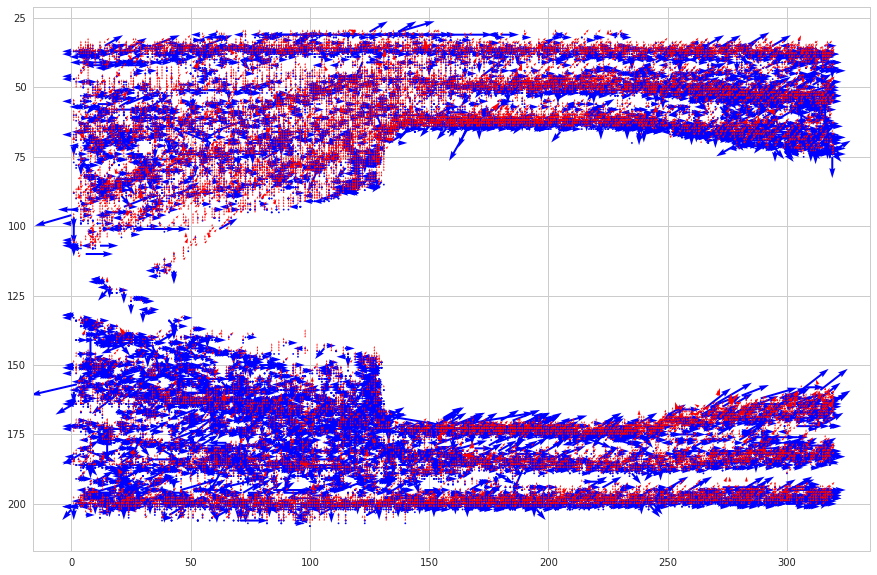

In [32]:
plot_all_arrows(df)

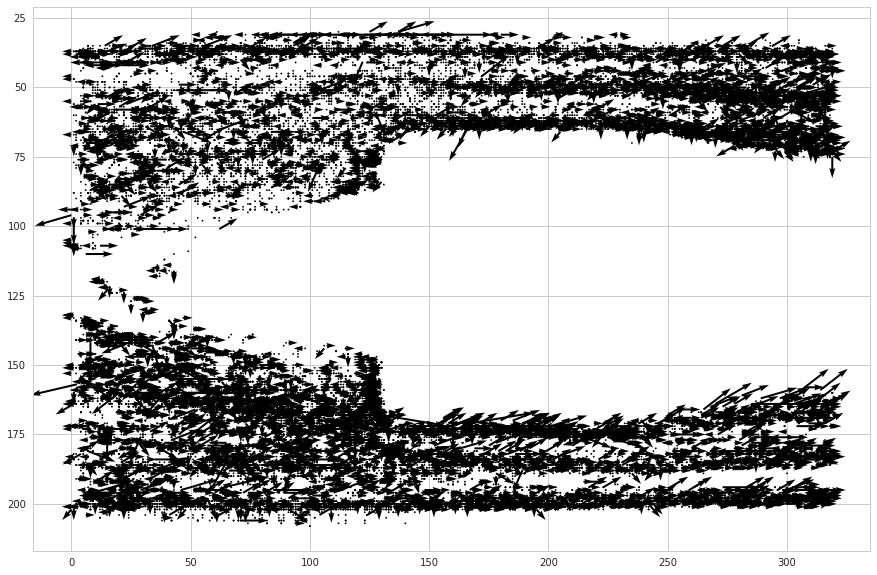

In [33]:
plot_arrows(df[df.cluster == 0])

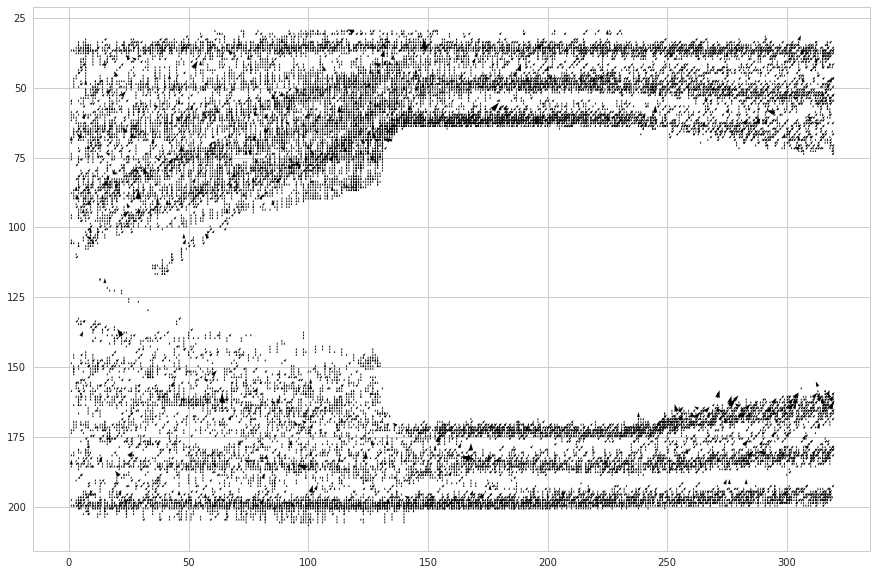

In [34]:
plot_arrows(df[df.cluster == 1])

/home/marlesson/anaconda3/lib/python3.6/site-packages/matplotlib/quiver.py:650: RuntimeWarning: Mean of empty slice.
  amean = a.mean()
/home/marlesson/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


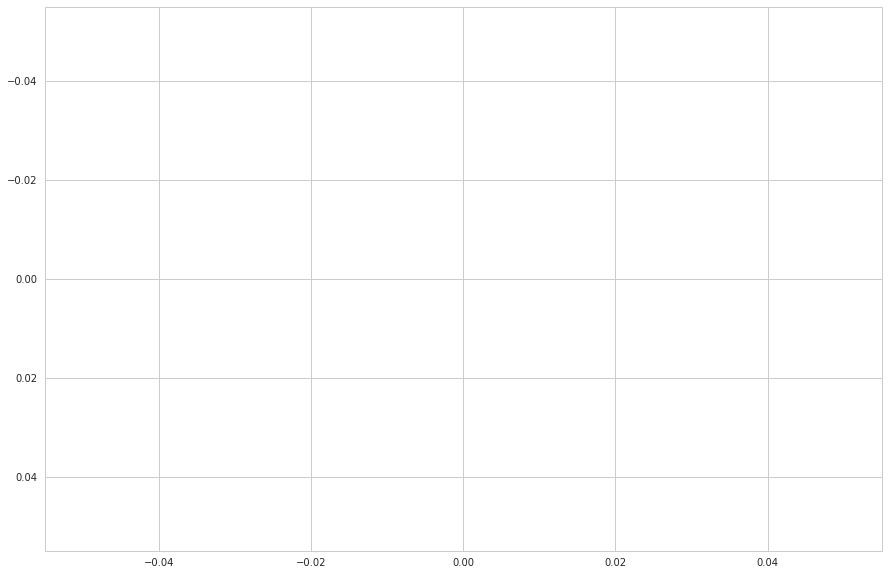

In [36]:
plot_arrows(df[df.cluster == 2])

/home/marlesson/anaconda3/lib/python3.6/site-packages/matplotlib/quiver.py:650: RuntimeWarning: Mean of empty slice.
  amean = a.mean()
/home/marlesson/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


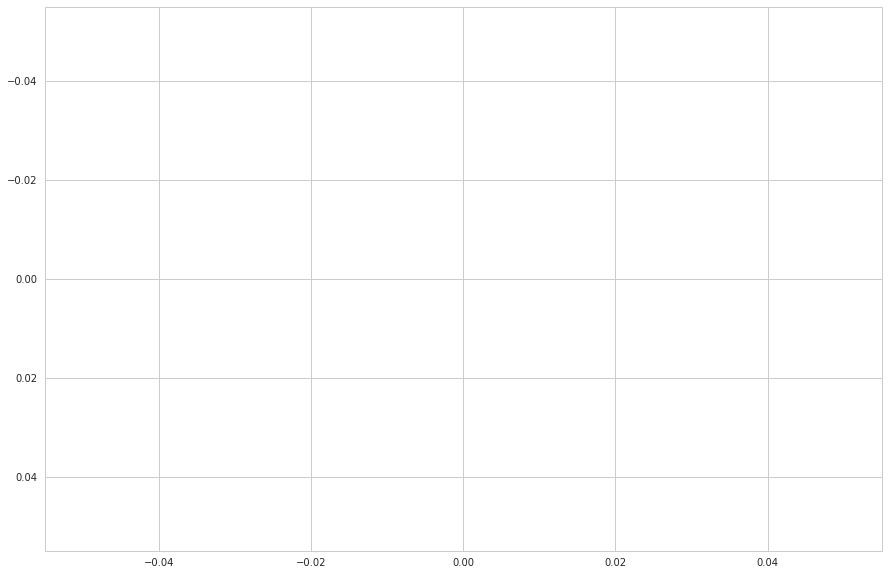

In [37]:
plot_arrows(df[df.cluster == 3])

/home/marlesson/anaconda3/lib/python3.6/site-packages/matplotlib/quiver.py:650: RuntimeWarning: Mean of empty slice.
  amean = a.mean()
/home/marlesson/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


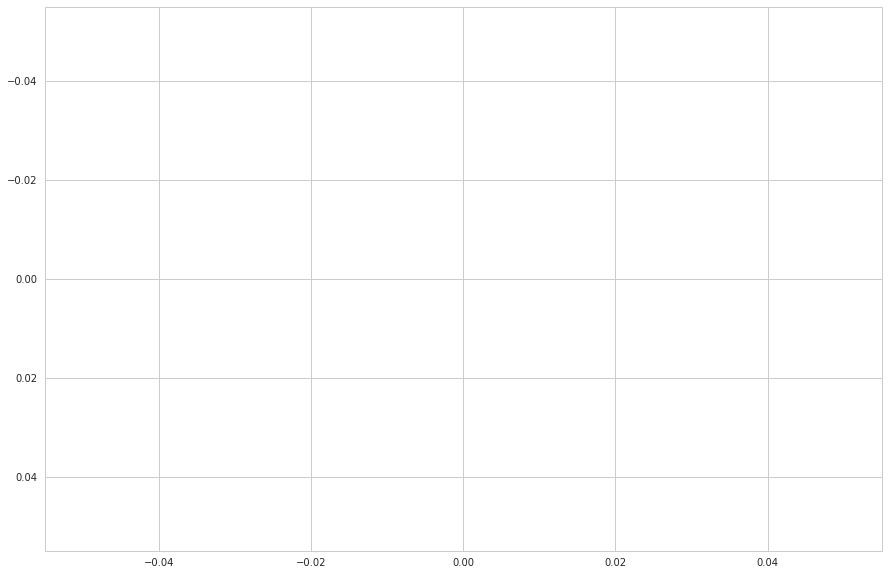

In [38]:
plot_arrows(df[df.cluster == 4])

In [39]:
def floatRgb(mag, cmin, cmax):
       """
       Return a tuple of floats between 0 and 1 for the red, green and
       blue amplitudes.
       """
       try:
              # normalize to [0,1]
              x = float(mag-cmin)/float(cmax-cmin)
       except:
              # cmax = cmin
              x = 0.5
       blue = min((max((4*(0.75-x), 0.)), 1.))*255
       red  = min((max((4*(x-0.25), 0.)), 1.))*255
       green= min((max((4*math.fabs(x-0.5)-1., 0.)), 1.))*255
       return [int(red), int(green), int(blue)]

In [40]:
rad = -0.7853981633974483
floatRgb(rad, -math.pi, math.pi)

[127, 0, 255]

In [41]:
rad = 0.7853981633974483
floatRgb(rad, -math.pi, math.pi)

[255, 0, 127]

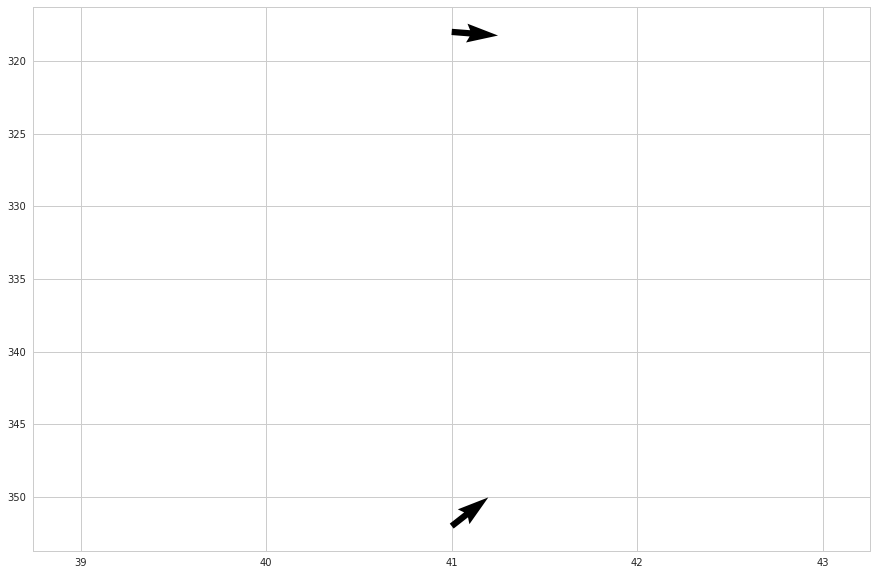

In [42]:
    #Plt
    plt.figure(figsize=(15,10))

    ax = plt.gca()
    ax.invert_yaxis()
    
    #plot
    plt.quiver(41, 318, 
               1, 1,  
               angles='xy', scale_units='xy')
    
    #plot
    plt.quiver(41, 352, 
               1, -10,  
               angles='xy', scale_units='xy')    
    plt.show()